In [80]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import torch
from torch.autograd import Variable
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from sklearn import metrics
from tqdm import tqdm

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/train.csv')
submission = pd.read_csv('data/sample_submission.csv')


In [130]:
train = train.drop(['X27', 'X29', 'X30', 'X33', 'X46', 'X47', 'X48'], axis = 1)

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# train.head(20)

In [5]:
# train.shape

In [6]:
# train.info()

In [7]:
# train.isnull().sum()

In [8]:
# train.describe()

In [9]:
for i in train.columns:
    if train[i].nunique() == 1:
        print(i)

X27
X29
X30
X33
X46
X47
X48


In [10]:
train['X13'].fillna(train['X13'].mean(), inplace = True)

In [11]:
label = train.pop('label')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train, label)

In [13]:
training_data = torch.from_numpy(X_train.values).type(torch.float32).to(DEVICE)
testing_data = torch.from_numpy(X_test.values).type(torch.float32).to(DEVICE)
training_label = torch.from_numpy(y_train.values).type(torch.float32).to(DEVICE)
testing_label = torch.from_numpy(y_test.values).type(torch.float32).to(DEVICE)

In [15]:
class Data(nn.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, pos):
        return self.X.iloc[pos], self.y.iloc[pos]

AttributeError: module 'torch.nn.utils' has no attribute 'data'

In [112]:
class FeedForward(nn.Module):
    def __init__(self, input_dimension, output_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm1d(input_dimension),
            nn.Linear(input_dimension, 100),
#             nn.Tanh(),
            nn.Linear(100, 100),
#             nn.ReLU(inplace = True),
            nn.Linear(100, 1)
        )
    def forward(self, x):
        return self.net(x).view(-1)

In [113]:
from math import ceil
total_size = len(X_train)
batch_size = 5000
iteration = 1000
epoch = iteration / (total_size / batch_size)
epoch = ceil(epoch)
epoch

15

In [114]:
training_loader = torch.utils.data.DataLoader(TensorDataset(training_data, training_label), batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(TensorDataset(testing_data, testing_label), batch_size = batch_size, shuffle = True)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size = batch_size, shuffle = False)

In [115]:
input_dimension = X_train.shape[1]
output_dimension = 1

In [133]:
model = FeedForward(input_dimension, output_dimension).to(DEVICE)
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [134]:
def get_predictions(loader, model, device):
    model.eval()
    saved = []
    true = []
    
    with torch.inference_mode():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            scores = torch.round(torch.sigmoid(scores))
            saved += scores.tolist()
            true += y.tolist()
    model.train()
    return saved, true

In [135]:
loss_ = []
iteration_ = []
eval_loss_ = []
for i in range(5):
    
#     predicted, true_label = get_predictions(validation_loader, model, device = DEVICE)
#     print(f'VALIDATION F1_SCORE: {f1_score([int(i) for i in predicted], true_label)}')
          
    for j, (x, y) in tqdm(enumerate(training_loader)):
    # x, y = next(iter(training_loader))
        model.train()
        pred = model(x)

        train_loss = criterion(pred, y)

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        iteration_.append(i)

        loss_.append(train_loss)

        probability, real = get_predictions(validation_loader, model, DEVICE)
        scores = f1_score(probability, real, average = 'macro')
        with torch.inference_mode():
            model.eval()
            for w, (x, y) in enumerate(validation_loader):
                prediction = model(x)
                eval_loss = criterion(prediction, y)
                eval_loss_.append(eval_loss)
        if j % 5 == 0:
            print(j)
            print(f'{i+1} | training_loss ==== {train_loss:.4f} | evaluating_loss ==== {eval_loss:.4f} | scores ==== {scores:.4f}')


1it [00:06,  6.95s/it]

0
1 | training_loss ==== 0.7329 | evaluating_loss ==== 0.6864 | scores ==== 0.3872


6it [00:40,  6.82s/it]

5
1 | training_loss ==== 0.6778 | evaluating_loss ==== 0.6956 | scores ==== 0.3618


11it [01:12,  6.46s/it]

10
1 | training_loss ==== 0.6259 | evaluating_loss ==== 0.6599 | scores ==== 0.4701


16it [01:44,  6.33s/it]

15
1 | training_loss ==== 0.5756 | evaluating_loss ==== 0.6016 | scores ==== 0.5466


21it [02:17,  6.52s/it]

20
1 | training_loss ==== 0.5229 | evaluating_loss ==== 0.5372 | scores ==== 0.6091


26it [02:49,  6.42s/it]

25
1 | training_loss ==== 0.4691 | evaluating_loss ==== 0.4714 | scores ==== 0.6454


31it [03:21,  6.43s/it]

30
1 | training_loss ==== 0.4132 | evaluating_loss ==== 0.4053 | scores ==== 0.6576


36it [03:53,  6.42s/it]

35
1 | training_loss ==== 0.3577 | evaluating_loss ==== 0.3486 | scores ==== 0.6554


41it [04:27,  6.63s/it]

40
1 | training_loss ==== 0.2955 | evaluating_loss ==== 0.2904 | scores ==== 0.6637


46it [05:00,  6.59s/it]

45
1 | training_loss ==== 0.2477 | evaluating_loss ==== 0.2381 | scores ==== 0.6629


51it [05:32,  6.34s/it]

50
1 | training_loss ==== 0.2004 | evaluating_loss ==== 0.1935 | scores ==== 0.6708


56it [06:03,  6.23s/it]

55
1 | training_loss ==== 0.1656 | evaluating_loss ==== 0.1609 | scores ==== 0.6772


61it [06:34,  6.18s/it]

60
1 | training_loss ==== 0.1356 | evaluating_loss ==== 0.1326 | scores ==== 0.6812


66it [07:05,  6.20s/it]

65
1 | training_loss ==== 0.1112 | evaluating_loss ==== 0.1214 | scores ==== 0.6855


69it [07:23,  6.43s/it]
1it [00:06,  6.18s/it]

0
2 | training_loss ==== 0.1074 | evaluating_loss ==== 0.1118 | scores ==== 0.6847


6it [00:37,  6.23s/it]

5
2 | training_loss ==== 0.0923 | evaluating_loss ==== 0.0978 | scores ==== 0.6904


11it [01:08,  6.18s/it]

10
2 | training_loss ==== 0.0951 | evaluating_loss ==== 0.0876 | scores ==== 0.6850


16it [01:40,  6.43s/it]

15
2 | training_loss ==== 0.0880 | evaluating_loss ==== 0.0972 | scores ==== 0.7027


21it [02:20,  7.70s/it]

20
2 | training_loss ==== 0.0908 | evaluating_loss ==== 0.0782 | scores ==== 0.6944


26it [02:56,  7.43s/it]

25
2 | training_loss ==== 0.0874 | evaluating_loss ==== 0.0821 | scores ==== 0.6906


31it [03:35,  8.19s/it]

30
2 | training_loss ==== 0.0843 | evaluating_loss ==== 0.0783 | scores ==== 0.6926


36it [04:12,  7.46s/it]

35
2 | training_loss ==== 0.0765 | evaluating_loss ==== 0.0891 | scores ==== 0.7045


41it [04:49,  7.29s/it]

40
2 | training_loss ==== 0.0773 | evaluating_loss ==== 0.0720 | scores ==== 0.7072


46it [05:31,  8.59s/it]

45
2 | training_loss ==== 0.0819 | evaluating_loss ==== 0.0697 | scores ==== 0.7070


51it [06:09,  7.70s/it]

50
2 | training_loss ==== 0.0719 | evaluating_loss ==== 0.0795 | scores ==== 0.6993


56it [06:53,  9.24s/it]

55
2 | training_loss ==== 0.0733 | evaluating_loss ==== 0.0769 | scores ==== 0.6886


61it [07:31,  8.08s/it]

60
2 | training_loss ==== 0.0741 | evaluating_loss ==== 0.0724 | scores ==== 0.6930


66it [08:18,  9.30s/it]

65
2 | training_loss ==== 0.0792 | evaluating_loss ==== 0.0751 | scores ==== 0.7006


69it [08:44,  7.60s/it]
1it [00:09,  9.12s/it]

0
3 | training_loss ==== 0.0741 | evaluating_loss ==== 0.0638 | scores ==== 0.6974


6it [00:50,  8.02s/it]

5
3 | training_loss ==== 0.0742 | evaluating_loss ==== 0.0719 | scores ==== 0.7050


11it [01:24,  7.16s/it]

10
3 | training_loss ==== 0.0719 | evaluating_loss ==== 0.0911 | scores ==== 0.7020


16it [01:56,  6.48s/it]

15
3 | training_loss ==== 0.0709 | evaluating_loss ==== 0.0729 | scores ==== 0.7005


21it [02:27,  6.22s/it]

20
3 | training_loss ==== 0.0659 | evaluating_loss ==== 0.0810 | scores ==== 0.7007


26it [02:58,  6.16s/it]

25
3 | training_loss ==== 0.0677 | evaluating_loss ==== 0.0747 | scores ==== 0.6948


31it [03:33,  7.12s/it]

30
3 | training_loss ==== 0.0806 | evaluating_loss ==== 0.0800 | scores ==== 0.7161


36it [04:05,  6.44s/it]

35
3 | training_loss ==== 0.0649 | evaluating_loss ==== 0.0687 | scores ==== 0.7213


41it [04:36,  6.23s/it]

40
3 | training_loss ==== 0.0824 | evaluating_loss ==== 0.0674 | scores ==== 0.7154


46it [05:07,  6.25s/it]

45
3 | training_loss ==== 0.0705 | evaluating_loss ==== 0.0748 | scores ==== 0.7172


51it [05:39,  6.25s/it]

50
3 | training_loss ==== 0.0712 | evaluating_loss ==== 0.0694 | scores ==== 0.7039


56it [06:10,  6.22s/it]

55
3 | training_loss ==== 0.0638 | evaluating_loss ==== 0.0761 | scores ==== 0.7019


61it [06:41,  6.29s/it]

60
3 | training_loss ==== 0.0651 | evaluating_loss ==== 0.0776 | scores ==== 0.7207


66it [07:12,  6.26s/it]

65
3 | training_loss ==== 0.0706 | evaluating_loss ==== 0.0884 | scores ==== 0.7058


69it [07:31,  6.54s/it]
1it [00:06,  6.38s/it]

0
4 | training_loss ==== 0.0728 | evaluating_loss ==== 0.0802 | scores ==== 0.6955


6it [00:37,  6.23s/it]

5
4 | training_loss ==== 0.0756 | evaluating_loss ==== 0.0741 | scores ==== 0.7167


11it [01:10,  6.65s/it]

10
4 | training_loss ==== 0.0645 | evaluating_loss ==== 0.0708 | scores ==== 0.7157


16it [01:46,  7.06s/it]

15
4 | training_loss ==== 0.0737 | evaluating_loss ==== 0.0793 | scores ==== 0.7023


21it [02:20,  6.94s/it]

20
4 | training_loss ==== 0.0780 | evaluating_loss ==== 0.0723 | scores ==== 0.7106


26it [02:54,  6.64s/it]

25
4 | training_loss ==== 0.0670 | evaluating_loss ==== 0.0630 | scores ==== 0.7189


31it [03:25,  6.41s/it]

30
4 | training_loss ==== 0.0710 | evaluating_loss ==== 0.0753 | scores ==== 0.7173


36it [03:57,  6.22s/it]

35
4 | training_loss ==== 0.0631 | evaluating_loss ==== 0.0733 | scores ==== 0.7143


41it [04:27,  6.09s/it]

40
4 | training_loss ==== 0.0692 | evaluating_loss ==== 0.0724 | scores ==== 0.7173


46it [04:58,  6.11s/it]

45
4 | training_loss ==== 0.0681 | evaluating_loss ==== 0.0739 | scores ==== 0.7217


51it [05:29,  6.17s/it]

50
4 | training_loss ==== 0.0757 | evaluating_loss ==== 0.0642 | scores ==== 0.7200


56it [05:59,  6.14s/it]

55
4 | training_loss ==== 0.0764 | evaluating_loss ==== 0.0677 | scores ==== 0.7191


61it [06:30,  6.20s/it]

60
4 | training_loss ==== 0.0715 | evaluating_loss ==== 0.0591 | scores ==== 0.7254


66it [07:01,  6.11s/it]

65
4 | training_loss ==== 0.0689 | evaluating_loss ==== 0.0740 | scores ==== 0.7276


69it [07:19,  6.37s/it]
1it [00:06,  6.12s/it]

0
5 | training_loss ==== 0.0626 | evaluating_loss ==== 0.0694 | scores ==== 0.7305


6it [00:36,  6.14s/it]

5
5 | training_loss ==== 0.0727 | evaluating_loss ==== 0.0817 | scores ==== 0.7288


11it [01:07,  6.07s/it]

10
5 | training_loss ==== 0.0782 | evaluating_loss ==== 0.0767 | scores ==== 0.7267


16it [01:37,  6.10s/it]

15
5 | training_loss ==== 0.0751 | evaluating_loss ==== 0.0702 | scores ==== 0.7250


21it [02:08,  6.04s/it]

20
5 | training_loss ==== 0.0613 | evaluating_loss ==== 0.0620 | scores ==== 0.7181


26it [02:38,  6.12s/it]

25
5 | training_loss ==== 0.0641 | evaluating_loss ==== 0.0626 | scores ==== 0.7146


31it [03:08,  6.07s/it]

30
5 | training_loss ==== 0.0730 | evaluating_loss ==== 0.0708 | scores ==== 0.7085


36it [03:39,  6.09s/it]

35
5 | training_loss ==== 0.0758 | evaluating_loss ==== 0.0741 | scores ==== 0.7173


41it [04:09,  6.09s/it]

40
5 | training_loss ==== 0.0802 | evaluating_loss ==== 0.0551 | scores ==== 0.7357


46it [04:40,  6.10s/it]

45
5 | training_loss ==== 0.0729 | evaluating_loss ==== 0.0759 | scores ==== 0.7261


51it [05:13,  6.86s/it]

50
5 | training_loss ==== 0.0710 | evaluating_loss ==== 0.0709 | scores ==== 0.7161


56it [05:46,  6.60s/it]

55
5 | training_loss ==== 0.0664 | evaluating_loss ==== 0.0735 | scores ==== 0.7313


61it [06:17,  6.32s/it]

60
5 | training_loss ==== 0.0736 | evaluating_loss ==== 0.0747 | scores ==== 0.7386


66it [06:50,  6.38s/it]

65
5 | training_loss ==== 0.0622 | evaluating_loss ==== 0.0625 | scores ==== 0.7331


69it [07:08,  6.21s/it]


In [ ]:
# torch.round(torch.sigmoid(prediction))
f1_score(probability, real)

In [306]:
np.set_printoptions(threshold = 1000000, precision = 2)
pd.set_option('display.max_row', 1000000)

In [79]:
pd.Series(torch.round(torch.sigmoid(prediction)).detach().numpy()).value_counts()

0.0    699
1.0      1
dtype: int64

In [322]:
prediction_pred = pd.Series(torch.round(torch.relu(prediction)).detach().numpy()).astype('int64')
prediction_pred[prediction_pred > 1]

Series([], dtype: int64)

In [324]:
prediction_pred.unique(), y_test.nunique()

(array([0], dtype=int64), 2)

In [262]:
len(loss_)

1725

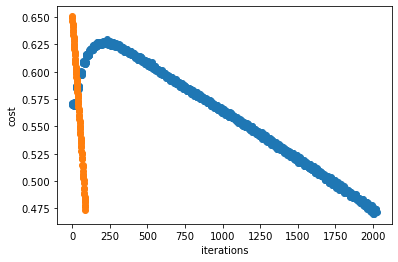

In [132]:
plt.scatter(list(range(len(eval_loss_))), [i.detach().numpy() for i in eval_loss_], cmap= 'blue')
plt.scatter(list(range(len(loss_))), [i.detach().numpy() for i in loss_], cmap = 'red')
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()

In [80]:
plt.scatter(list(range(len(eval_loss_))), [i.detach().numpy() for i in eval_loss_], cmap= 'blue')
plt.scatter(list(range(len(loss_))), [i.detach().numpy() for i in loss_], cmap = 'red')
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()

(344098,)